#  Deep Neural Network Classifier


A _deep neural network_ (DNN) is a relatively simple model of brain neurons that, by composing
multiple linear transformations and nonlinear _activation functions_,
allows obtaining highly nonlinear mappings that can be used for classification
or regression tasks.

Suppose there are two sets of data points $\mathcal{A}$ and $\mathcal{B}$:

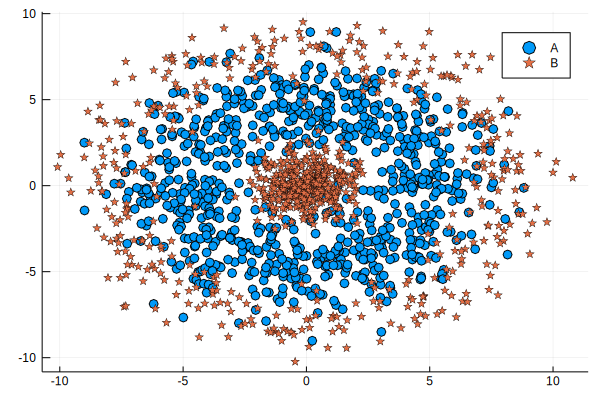

In [1]:
using Random, Statistics, LinearAlgebra

Random.seed!(12) # For reproducibility

# construct dataset
Na, Nb = 800,800 # number of data points of set A and B
N = Na+Nb
rhoa = 5.

A = hcat([ rhoa.*[ cos(theta);  sin(theta)] for theta in range(0,2*pi;length=Na) ]...)
A .+= 1.5.*randn(size(A))
B = zeros(2, div(Nb,2))
rhob = 8.
B = [B hcat([ rhob.*[ cos(theta);  sin(theta)] for theta in range(0,2*pi;length=div(Nb,2)) ]...)]
B .+= randn(size(B))

D = [A B] # data matrix 
yt = [ones(Bool,Na); zeros(Bool,Nb)] # labels: 1 is set A, 0 is set B

# preprocess data
D .-= mean(D)
D ./= sqrt.(var(D,dims=2))

using Plots
scatter(A[1,:],A[2,:]; m=:o, label  = "A")
scatter!(B[1,:],B[2,:]; m=:star, label  = "B")



A classifier seeks to find the lines that separate these sets. Clearly, a linear classifier cannot perform such task. On the contrary, a DNN with its nonlinear behavior can be _trained_ to perform such task. 

Firstly the DNN has to be constructed. Here a three layer configuration is used:

$$
\begin{aligned}
\mathbf{y} &= \mathcal{S} ( \mathbf{W}_3 \mathbf{L}_2 +b_3 ) \\
\mathbf{L}_2 &= \mathcal{S} ( \mathbf{W}_2 \mathbf{L}_1 +b_2 ) \\
\mathbf{L}_1 &= \mathcal{S} ( \mathbf{W}_1 \mathbf{D} + b_1 ), \\
\end{aligned}
$$

where $\mathcal{S}$ are sigmoid functions modeling the activations of the neurons, $\mathbf{W}_i$ are the _weights_ of the connections between the neighbor layers neurons, $b_i$ are the biases of the layers, $\mathbf{D}$ are the training data points and $\mathbf{y}$ is the output of the DNN. 

This DNN can be constructed using `StructuredOptimization` together with `AbstractOperators`:

In [2]:
using AbstractOperators, StructuredOptimization

n = 7  # inner layers nodes

dim_in, N = size(D)

# weights are initialized with random variables normalized 
# by the inverse square root of the input output dimensions 

W1 = Variable(sqrt(2/(2+n)*N)*randn(n,dim_in)) # first layer
S1 = Sigmoid((n,N))
b1 = Variable(1)

W2 = Variable(sqrt(2/(2*n))*randn(n,n))        # second layer
S2 = Sigmoid((n,N))
b2 = Variable(1)

W3 = Variable(sqrt(2/(n+1))*randn(1,n))        # third layer
S3 = Sigmoid((1,N))
b3 = Variable(1)

L1 = S1*(W1* D.+b1)
L2 = S2*(W2*L1.+b2)
y  = S3*(W3*L2.+b3);


The training is performed by matching the output of the layer $\mathbf{y}$ with the labels $\tilde{\mathbf{y}}$ by finding the optimal weights $\mathbf{W}_i$ and biases $b_i$. 

This can be achieved by solving the following optimization problem:

$$
\underset{\mathbf{W}_{1},\mathbf{W}_{2},\mathbf{W}_{3}, b_{1},b_{2},b_{3} }{\text{minimize}} -\sum_{n = 1}^N \overbrace{\left(\tilde{y}_n \log (y_n) +(1-\tilde{y}_n) \log (1-y_n) \right)}^{f}+ \sum_{i = 1}^3 \overbrace{ \lambda_i \| \text{vec} (\mathbf{W}_i)\|_{1}}^{g}
$$

where $f$ is the _cross entropy loss_ function and $g$ is a regularization function which prevents _over-fitting_ and promotes enforcing the weights $\mathbf{W}_i$ to be sparse matrices. 

The parameters $\lambda_i$ can be found using a K-fold cross validation strategy which is not reported here for brevity.


In [3]:
lambda = 0.0031622 # lambda obtained from K-fold CV

lambda1 = lambda/(2*n)
lambda2 = lambda/(n+n)
lambda3 = lambda/n

g = lambda1*norm(W1,1)+lambda2*norm(W2,1)+lambda3*norm(W3,1)

@minimize crossentropy(y,yt) + g with PANOC(tol = 1e-4, maxit=1500);


Now that the weights and biases are obtained it is possible to check the regions that are identified by the trained DNN.


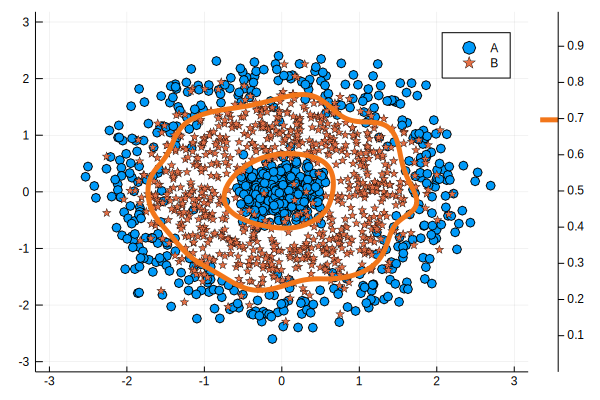

In [4]:
xx = range(-3,3;length=200) # define grid of points
yy = range(-3,3;length=200)

R = vcat([[xi yi] for yi in yy, xi in xx][:]...)' # new inputs to trained DNN
S = Sigmoid((n,size(R,2)))
Sout = Sigmoid((1,size(R,2)))

L1 = S*(~W1* R .+ ~b1)
L2 = S*(~W2*L1 .+ ~b2)
r  = Sout*(~W3*L2 .+ ~b3) # new DNN output

r = reshape(r,200,200)   
scatter(D[1,Na+1:end],D[2,Na+1:end]; m=:o, label = "A")
scatter!(D[1,1:Na],D[2,1:Na]; m=:star, label = "B")
contour!(xx,yy,r; levels = 0.7*[maximum(r)], linewidths = 5)
